# Clasificador Cirilico
---
En este notebook se detalla como dado un dataset compuesto de imagenes de letras cirilicas, generamos un modelo en el cual, dado una cierta imagen de entrada, donde esta sea una letra del alfabeto cirilico, se predice que letra es esta.


### 1) Importamos todas las librerias necesarias que vamos a usar
---



In [1]:
# Para trabajar con archivos, importar, exportar.
import os
import pickle
import gzip

# Manipulacion del dataset/array
import pandas as pd
import numpy as np

# Plots
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

# Imágenes
import cv2 as cv
from PIL import Image
from skimage.color import rgb2grey,rgb2gray, rgba2rgb

# SKLearn
import scikitplot as skplt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import plot_confusion_matrix
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

### 2) Leemos el dataset
---
El archivo del dataset  cyrilloc.csv fue generado por mí, para ver como generé este archivo, vease el notebook "generador dataframe cirilico.ipynb", que se encuentra en el mismo repositorio.

Las imagenes de las letras cirilicas fueron sacadas de [Kaggle](https://www.kaggle.com/gregvial/comnist). <br>

El dataset de Kaggle consiste en imagenes tanto cirilicas como latinas, en mi caso solamente usé las cirilicas, pero los conceptos aplicados en este notebook, son facilmente extrapolables al otro alfabeto. <br>

En este dataset encontramos alrededor de unas 15.000 imagenes, organizadas en carpetas, donde cada una de estas en contiene imagenes de la letra correspondiente, por ejemplo las imagenes de la letra  "Ж" se encuentran en la carpeta "dataset/Cyrillic/Ж/". El archivo ".csv" fue generado siguiendo esta lógica.



Aquí podemos leer el dataset e imprimir el encabezado para ver la organizacion del dataset, es decir las columnas y las filas

In [2]:
dataset = pd.read_csv("dataset/Cyrillic/cyrillic.csv", index_col=0)
dataset.head()

,label,file
letter,,
А,1,А (1).png
А,1,А (2).png
А,1,А (3).png
А,1,А (4).png
А,1,А (5).png


#### Por si el lector no se encuentra familiarizado con el alfabeto cirílico, en particular el ruso, adjunto la siguiente imagen.
![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/00Russian_Alphabet_3.svg/673px-00Russian_Alphabet_3.svg.png)

Aquí solamente realizo una impresión de la primera fila para visualizar la estructura del dataset, podemos ver que:
 - Label: es la etiqueta en número de la letra en ruso, osea 1=A, 2=В, 3=Б,...,  y así sucesivamente hasta el 33, esta columna esta pensado como variable Y, osea la salida
 - Name: es el nombre de la letra
 - file: es la ruta en donde se encuentra almacenada la imagen de la letra

In [3]:
#La primera letra es una "a" en ruso
dataset.iloc[1]

label            1
file     А (2).png
Name: А, dtype: object

### 3) Leemos la imagen
---
Lo siguiente que hago es leer una imagen y mostrarla, para esto creo una función para ganar en reusabilidad


Letra: А


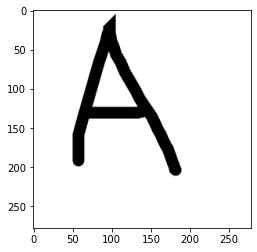

Letra: Б


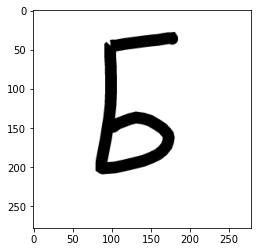

In [4]:
def get_image(letra, root="dataset/Cyrillic/"):
    """
    Recibe una fila de pandas, busque la imagen en la ruta,
    abre la imagen y devuelve la imagen como una matriz numpy.
    """
    file_path = os.path.join(root, letra.name)
    file_path = os.path.join(file_path, letra.file)
    #print(file_path)
    img = Image.open(file_path)
    return np.array(img)

#Para probar la funcion seleccione la primera fila de dataset
letra_de_ejemplo1=dataset.iloc[1]

print(f"Letra: {letra_de_ejemplo1.name}")
#para mostrar la imagen uso Matplotlib, y la función
plt.imshow(get_image(letra_de_ejemplo1))
plt.show()

#Hago lo mismo pero con otra letra
letra_de_ejemplo2=dataset.iloc[733]

print(f"Letra: {letra_de_ejemplo2.name}")
plt.imshow(get_image(letra_de_ejemplo2))
plt.show()

Aca podemos ver como la función me devuelve un numpy array,esto es necesario porque necesitamos una forma en que la imagen pueda ser interpretada, y en nuestro caso para esto la hacemos un array

In [5]:
#Recordar, esta funcion me convierte la imagen en un np.array
get_image(letra_de_ejemplo2)

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

### 4) Converción de la imagen en blanco y negro
---
Usar las imagenes en color ocupa mucho espacio y no es eficiente, el RGB tiene 3 canales, uno por cada color, en cambio si hacemos en blanco y negro tendriamos 1, y con esto simplificamos el modelo y reducimos las dimensiones del modelo

Letra: Б 
 
 [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


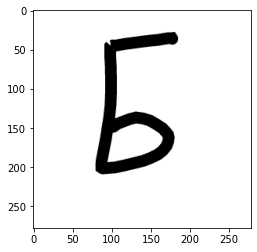

In [6]:
#Obtengo y guardo la imagen en una variable
imagen_gris = rgb2gray(rgba2rgb(get_image(letra_de_ejemplo2)))
#Imprimo la imagen como hice arriba
plt.imshow(imagen_gris, cmap=mpl.cm.gray)

print(f'Letra: {letra_de_ejemplo2.name} \n \n', imagen_gris)

### 5) Aplicación de filtro Gaussiano
---
Este filtro se aplica para reducir el ruido que pueda tener la imagen  y reducir algunas detalles, además de producir un suavizado en los bordes

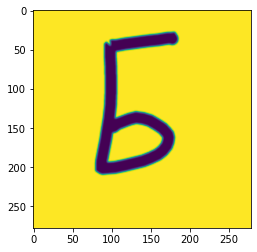

In [7]:
blur = cv.GaussianBlur(imagen_gris,(5,5),0)
plt.imshow(blur)

**Aclaración:** La imagen sigue siendo en blanco y negro, es solo por un tema de matplotlib, que no se visualiza de esta forma

### 6) Recortar la imagen
---
Este paso se realiza para disminuir aún mas la cantidad de variables que se utilizan para representar cada imagen. <br>
Cada imagen del dataset tiene un resolución de 276x276, donde decidí reducirlo a 64x64, ya que me parece un tamaño razonable y no se pierden detalles de la imagen ni se deforma la misma

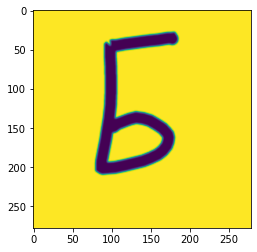

In [8]:
blur_recortada = cv.resize(blur,(64,64))
plt.imshow(blur)

### 7) Obtencion de feature matrix o matriz de carácteristicas o matriz HOG

HOG es una técnica para transformar una imagen en un histograma de gradientes y posteriormente utilizar los histogramas para hacer una matriz 1D que se utilizaría para entrenar un modelo, ya que las imágenes son convertidas en un formato que un algoritmo de machine learning puede entender.

La clasificación y la prediccion de la imagenes en nuestro caso, se basan en un método de extracción y descripción de características locales llamado Histograma de Gradientes Orientados (HOG). Con el uso de diferentes detectores de características (Ejemplo: SIFT, Shi-Thomas, ORB, FAST etc.) podemos localizar las características así como emparejar las características extraídas entre múltiples imágenes. Pero para utilizar la información para el entrenamiento de un modelo necesitamos las características extraídas en forma de vector 1D (como [x1,x2,..,xn]). La idea de HOG se basó en la misma intuición.[fuente](https://medium.com/swlh/histogram-of-oriented-gradients-hog-for-multiclass-image-classification-and-image-recommendation-cf0ea2caaae8)
<br>


La idea consistente en:
Una imagen se divide en celdas de forma cuadriculada, y para los píxeles de cada celda se compila un histograma de direcciones de gradiente o HOG. Para mejorar la invariabilidad a las luces y sombras de una imagen, las celdas se normalizan por bloques, lo que significa que se calcula un valor de intensidad para una región más grande de una imagen llamada bloque y se utiliza para normalizar por contraste todos los histogramas a nivel de celda dentro de cada bloque. El vector de características HOG de la imagen es la concatenación de estos histogramas a nivel de celda.




#### Ejemplo HOG Matrix
Por cada bloque, podemos ver como se generar una histograma de gradientes orientados, que nos sirven para describir las carácteristicas de la imagen y que son necesarias para el algoritmo de machine learning. <br>
![alt text](https://customers.pyimagesearch.com/wp-content/uploads/2015/03/hog_histogram_animation.gif)

#### Cell, Blocks, y pixeles
<br>
Aquí podemos ver las divisiones de las imagenes
![alt text](https://i.stack.imgur.com/IiF4M.gif)

Para obtener la matriz HOG de una imagen simplemente realizamos lo siguiente:
- hog_features: variable en donde se guarda la matriz/array que necesita el modelo de machine learning en formate 1D.
- hog_image: la imagen para visualizar.

Aquí podremos observar como se conservan las carácteristicas mas destables de la imagen y aun así se puede reconocer la letra con gran facilidad y a un menor costo computacional

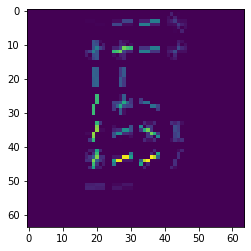

In [9]:
hog_features, hog_image = hog(blur_recortada,
                              visualize=True,
                              orientations=8,
                              block_norm='L2-Hys',
                              pixels_per_cell=(8, 8),cells_per_block=(2,2))
plt.imshow(hog_image)

In [10]:
#Longitud de la imagen
len(hog_image)

64

### 8) Creacion de función para despues generar un loop con todas las imagenes y obtener sus caracteristicas.
---
La funcion va a realizar lo siguiente
<br>

1. Recibe una imagen
1. La achica
1. La hace blanco y negro
1. Le aplica filtro gaussiano
1. Obtengo la matriz HOG
1. Devuelve esta matriz

In [11]:
def create_features(img):
    #achicamos la imagen
    imagen_achicada=cv.resize(img,(64,64))
    # flatten three channel color image
    #color_features = imagen_achicada.flatten()
    # convert image to greyscale
    grey_image = rgb2gray(rgba2rgb(imagen_achicada)) #Estaba usando esto "rgb2grey" pero esta deprecated, asi que lo cambié por esto
    

    blur = cv.GaussianBlur(grey_image,(5,5),0)
    # get HOG features from greyscale image
    hog_features = hog(blur,orientations=8, block_norm='L2-Hys', pixels_per_cell=(8, 8),cells_per_block=(2,2))
    # combine color and hog features into a single array

    flat_features = np.hstack(hog_features)
    return flat_features

imagen = get_image(letra_de_ejemplo2)
imagen_features = create_features(imagen)



Longitud de la cantidad de features de cada imagen

In [12]:
features_length = len(imagen_features)
features_length

1568

Cantidad de imagenes en el dataset

In [13]:
len(dataset.index)

15232

### 9) Loopeamos para obtener la matrix hog de todas las imagenes del dataset
---
En este paso, vamos a usar la función creada en el punto 8) para obtener un array con todas las características de cada imagen del dataset, que despues voy a usar estas características para entrenar el modelo

La función create_feature_matrix realiza lo siguiente:
 
1. Recibe el dataset
2. Declara una variable para ir almacenando todas las features de las imagenes, donde 1568 es la cantidad de variables de la imagen
3. En el ciclo "For" vamos recorriendo los indices del dataset y asi obteniendo las imagenes y el HOG de las mismas, para ir anexandolas/append a la variable creada anteriormente.
4. Una vez terminado todo el ciclo "For", devuelvo la matriz de características

In [14]:
from tqdm import tqdm
# me parecia muy lento y le agregué una barra de carga de aca
# https://github.com/tqdm/tqdm
def create_feature_matrix(dataset):

    features_list = np.empty((0, 1568))
    
    for i in tqdm(range(0,len(dataset.index))): 
        # Cargamos la imagen
        img = get_image(dataset.iloc[i])
        # Obtenemos las features de cada imagen
        image_features = create_features(img)
        # Anexamos al array que creamos
        features_list = np.append(features_list, np.array([image_features]), axis=0)
        

    # Convertimos la lista de array en una matriz
    feature_matrix = np.array(features_list)
    return feature_matrix

feature_matrix = create_feature_matrix(dataset)

#https://www.kaggle.com/manikg/training-svm-classifier-with-hog-features

100%|██████████| 15232/15232 [11:45<00:00, 21.59it/s]


#### 9.1) Opcionalmente, podemos guardar esto para no realizarlo a cada rato con la libreria pickle, ya que es un proceso costoso, ademas de que me resultó util, para trabajar con google colab y así no exportar todas las imagenes
---

In [15]:
#exporto con pickle para google colab, no es necesario, y lo comprimo porque github tiene un límite de 100mb por archivo
pkl_filename = "feature_matrix.pkl"
with gzip.open(pkl_filename, 'wb') as file:
    pickle.dump(feature_matrix, file, protocol=-1) 




Por si queremos utilizar el archivo si es que lo tenemos en nuestra carpeta, basta con descomentar las siguientes lineas:

In [16]:
#pkl_filename = "feature_matrix.pkl"
#with gzip.open("feature_matrix.pkl", 'rb') as f:
#    feature_matrix = pickle.load(f) 


### 10) Train-Test Split
---
Aquí realizamos la división entre Test-Train, tanto de las variables X como Y, donde:
- X: la feature matrix o HOG matrix, que creamos previamente cada una de  1568 características
- y: solo las etiquetas del dataframe que creamos al comienzo, donde indican el numero de letras
Por ejemplo el primer elemento de X, corresponde con el primer elemento de "y", osea de la letra "a", y así sucesivamente

Un parámetro adicional que uso es el "stratify", donde estratificación significa que el método train_test_split devuelve subconjuntos de entrenamiento y prueba que tienen las mismas proporciones de etiquetas de clase que el conjunto de datos de entrada.
Esto es util ya que quiero tener las mismas cantidades proporcionalmente para testear el modelo


In [17]:
X = pd.DataFrame(feature_matrix)
y = pd.Series(dataset.label.values)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=666,
                                                    stratify=y) 

# Vemos la cantidad de cada elemento, es decir de cada letra
pd.Series(y_train).value_counts()

6     461
21    441
19    410
15    406
18    394
3     390
23    389
17    379
14    376
1     375
11    373
5     372
16    372
25    371
8     370
22    370
32    369
28    367
12    367
31    366
20    365
10    358
24    358
27    357
2     355
33    350
13    346
26    345
9     345
30    342
4     339
29    332
7     275
dtype: int64

### 11) Escalamos los datos
---
Este paso es crucial para el siguiente, que es PCA, donde el mismo requiere que escalemos los datos

In [18]:
print('Feature matrix shape es: ', feature_matrix.shape)

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

Feature matrix shape es:  (15232, 1568)


#### 11.1) Opcionalmente, guardamos la variable "sc" para usarla en cualquier lado
---

In [19]:
#guardo el StandardScaler para la aplicación web
pkl_filename = "sc.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(sc, file)

### 12) Explicación de PCA
---
El análisis de componentes principales, o PCA, es un método de reducción de la dimensionalidad que se utiliza a menudo para reducir la dimensionalidad de grandes conjuntos de datos, transformando un gran conjunto de variables en uno más pequeño que siga conteniendo la mayor parte de la información del conjunto grande.

La reducción del número de variables de un conjunto de datos se produce naturalmente a expensas de la precisión, pero el truco de la reducción de la dimensionalidad consiste en cambiar un poco de precisión por simplicidad. Porque los conjuntos de datos más pequeños son más fáciles de explorar y visualizar y hacen que el análisis de los datos sea mucho más fácil y rápido para los algoritmos de aprendizaje automático sin variables extrañas que procesar.

**En resumen**, la idea del PCA es sencilla: reducir el número de variables de un conjunto de datos, conservando la mayor cantidad de información posible.

Una forma más común de acelerar un algoritmo de aprendizaje automático es utilizar el Análisis de Componentes Principales (PCA). Si su algoritmo de aprendizaje es demasiado lento porque la dimensión de entrada es demasiado alta, el uso de PCA para acelerarlo puede ser una opción razonable. Esta es probablemente la aplicación más común del PCA.

**Varianza explicada (Explained Variance)**
La varianza explicada indica la cantidad de información (varianza) que puede atribuirse a cada uno de los componentes principales. Esto es importante, ya que aunque se puede convertir un espacio de  por ejemplo, 4 dimensiones en un espacio de 2 dimensiones, se pierde parte de la varianza (información) al hacerlo. La idea de la varianza es conseguir la cantidad de carácterísticas que puedan explicar aproximadamente el 95% de la varianza, de esta forma, mejoraríamos el trade-off entre precisión/velocidad

Fuentes: [1](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60) y [2](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)


#### Gráfico de PCA para explicar la varianza

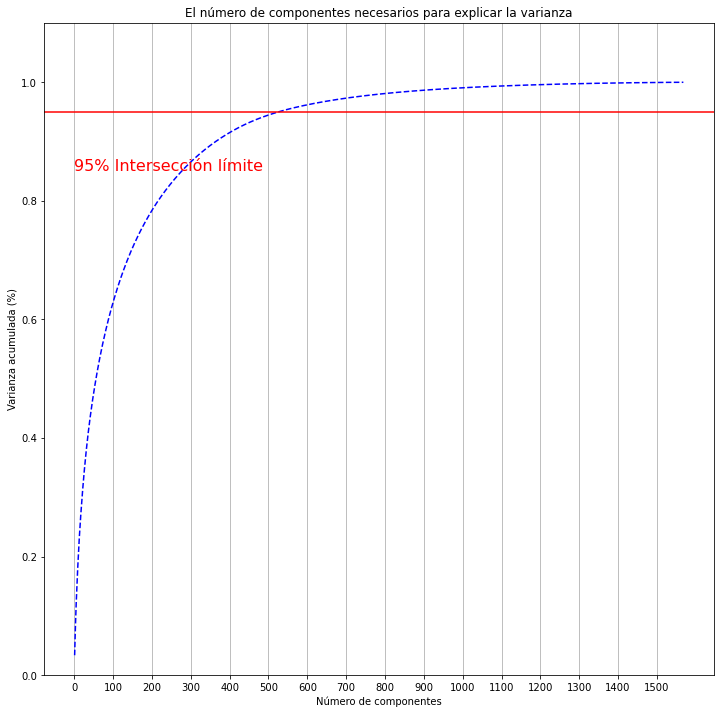

In [20]:
plt.rcParams["figure.figsize"] = (12,12)
pca = PCA().fit(X_train_scaled)

fig, ax = plt.subplots()
xi = np.arange(1, features_length+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, linestyle='--', color='b')

plt.xlabel('Número de componentes')
plt.xticks(np.arange(0, features_length+1, step=100)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Varianza acumulada (%)')
plt.title('El número de componentes necesarios para explicar la varianza')

#Linea de 0.95 %
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% Intersección límite', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

Con el gráfico de arriba podemos apreciar que la varianza del 95% se encuentra representada por aproximadamente entre 500-600 features, de esta manera eligiendo un número entre ese límite, podremos tener una buena representación de nuestras imagenes y así obtener una buena relación recisión-velocidad. 


Tenemos un total de 1568 características por imagen

In [21]:
pca.explained_variance_ratio_.shape

(1568,)

### 13) Aplicación de PCA
---
Ahora debemos aplicar este análisis a todas las features, es decir reducir su dimención.
Si aplicamos lo siguiente "pca = PCA(.95)", estaríamos la cantidad de features que presente el 95% de la varianza.
Realizando pruebas me di cuenta que este número es menor de 550 features, y decidí ir por 575, para tener un rango un poco mas del 95% de la varianza, aunque ambos pensamientos llevan a buenos resultados.

In [22]:
pca = PCA(n_components=575)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print('PCA matrix train shape es: ', X_train_pca.shape)



PCA matrix train shape es:  (12185, 575)


Podemos apreciar que pasamos de 1568 features a tan solo 575, eso cerca de 1/3 de las features para explicar el 95% de la varianza, y conservar gran cantidad de información de las imagenes.

In [23]:
print('PCA matrix test shape es: ', X_test_pca.shape)


PCA matrix test shape es:  (3047, 575)


#### 13.1) Opcionalmente podemos guardar la variable pca, ya que tarda bastante en ejecutarse

In [24]:
#Guardo el objeto pca, para la aplicación web
pkl_filename = "pca.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(pca, file)

### 14) Búsqueda de Hiper-parámetros
---

Para la obtención de los Hiper-parámetros voy a utilizar el método de Grid Search.
Este método es bastante sencillo, consiste en pasarle todos los parámetros que queres que se prueben para un determinado modelo y el método te devuelve todas las combinaciones probadas, el modelo con el parámetro óptimo y los parámetros optimos de entre todas las combinaciones que le pasamos.

La desventaja de este acercamiento es que es bastante costoso, en mi caso toma cerca de 1:30 hs, en ejecutarse todas las combinaciones, por lo que decidí pasarle pocos parámetros para probar.

Otro enfoque sería utilizar el RandomizedSearchCV, o Random Grid Search, que básicamente es como la búsqueda en grilla, nada mas que prueba una cierta cantidad de veces de manera aleatoria las combinaciones de los parámetros que le pasamos. Este enfoque es util para tener una idea aproximada de donde se encuentra los par óptimos, se recomienda tambien que seguido de una búsqueda RandomizedSearchCV, se utilice el método Grid Search normal, pero esta vez pasando menos parámetros en funcion de los resultados del RandomizedSearchCV

Párticularmente  probé el enfoque de RandomizedSearchCV y luego Grid Search, como se muestra a continuación.

*RandomizedSearchCV al ser random los parámetros seleccionados para el modelo final pueden cambiar al momento de leer el notebook*

### *RandomizedSearchCV*

In [25]:
grid_params = {'kernel': ["linear","poly","rbf","sigmoid"], 'C': [1,5,10,15,50], 'gamma':['auto',"scale",5,10,20,50]}
random_cv = RandomizedSearchCV(SVC(), grid_params, n_iter=100, cv=3, n_jobs=-1,random_state=666)

In [26]:
%%time
random_cv_results = random_cv.fit(X_train_pca, y_train)

Wall time: 1h 41min 3s


Resultados de la búsqueda

In [27]:
random_cv_results.best_estimator_

SVC(C=5, gamma=20, kernel='poly')

Mejor Score de la búsqueda:

In [28]:
random_cv_results.best_score_

0.8768153175965429

### *GridSearchCV*

Ahora reduje un poco más los parámetros que le pasamos, pero no mucho.

In [29]:
grid_params = {'kernel': ["linear","poly","rbf","sigmoid"], 'C': [1,5,10], 'gamma':['auto',"scale",5,10]}
gs = GridSearchCV(SVC(), grid_params,  cv = 5, n_jobs = -1 )

In [30]:
%%time
gs_results = gs.fit(X_train_pca, y_train)

Wall time: 1h 19min 38s


Score obtenido, podemos apreciar una ligera mejora, en comparación con el enfoque random

In [31]:
gs_results.best_score_

0.8891259745588839

#### *Los parámetros definitivos*

In [32]:
gs_results.best_params_

{'C': 1, 'gamma': 5, 'kernel': 'poly'}

**Parámetros**
- 'C': 1
- 'gamma': 5
- 'kernel': 'poly'

*El grado del polinomio es 3 por defecto.*


Comparamos nuestro modelo con los datos de X_test

In [33]:
y_pr = gs_results.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pr)


Podemos observar que el valor de accuracy es de 90%, lo cual es un resultado satisfactorio

In [34]:
accuracy

0.9015425008204792

### 15) Entramiento del modelo final
---
Ahora procedemos a crear el modelo final con los parámetros que obtuvimos previamente

In [35]:
#svm = SVC(kernel='linear', probability=True, random_state=42,verbose=10)
svm = SVC(kernel='poly', gamma=5,C=1, random_state=42,verbose=10,probability=True)


In [36]:
%%time
kfold = KFold(n_splits=5)
model_kfold = SVC(kernel='poly', gamma=5,C=1, random_state=42,verbose=10,probability=True)
results_kfold = cross_val_score(model_kfold, X_train_pca, y_train, cv=kfold)
print("Accuracy promedio de los 5 folds: %.6f%%" % (results_kfold.mean()*100.0)) 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Accuracy promedio de los 5 folds: 88.904391%
Wall time: 14min 45s


In [37]:
print(f"Resultados de accuracy de cada fold \n{results_kfold}")

Resultados de accuracy de cada fold 
[0.89495281 0.88961838 0.89125975 0.87607714 0.89331145]


In [38]:
%%time
svm.fit(X_train_pca, y_train)

[LibSVM]Wall time: 5min 6s


SVC(C=1, gamma=5, kernel='poly', probability=True, random_state=42, verbose=10)

In [39]:
X_test_pca.shape

(3047, 575)

In [40]:
# generate predictions
y_pred = svm.predict(X_test_pca)
# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
#print('Model accuracy is: ', accuracy)

Podemos observar que con los datos de test, obtuvimos un 90% de accuracy, por lo tanto, vamos a proceder a realizar otras métricas del modelo

In [41]:
print('Accuracy del modelo: ', accuracy)

Accuracy del modelo:  0.9015425008204792


In [42]:
#exporto con pickle para google colab, no es necesario
pkl_filename = "model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svm, file)

### 15) Matriz de Confusión
---
Cada columna de la matriz representa el número de predicciones de cada clase, mientras que cada fila representa a las instancias en la clase real. Uno de los beneficios de las matrices de confusión es que facilitan ver si el sistema está confundiendo dos clases.

Generamos la matriz de confusión

In [43]:
cm=confusion_matrix(y_test, y_pred)

In [44]:
alfabeto= "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ"

Mapa de calor de la matriz de confusión, ya que la función built-in de sklearn, produce el mismo gráfico, pero es muy pequeño, por eso decidí crearlo yo mismo

<AxesSubplot:>

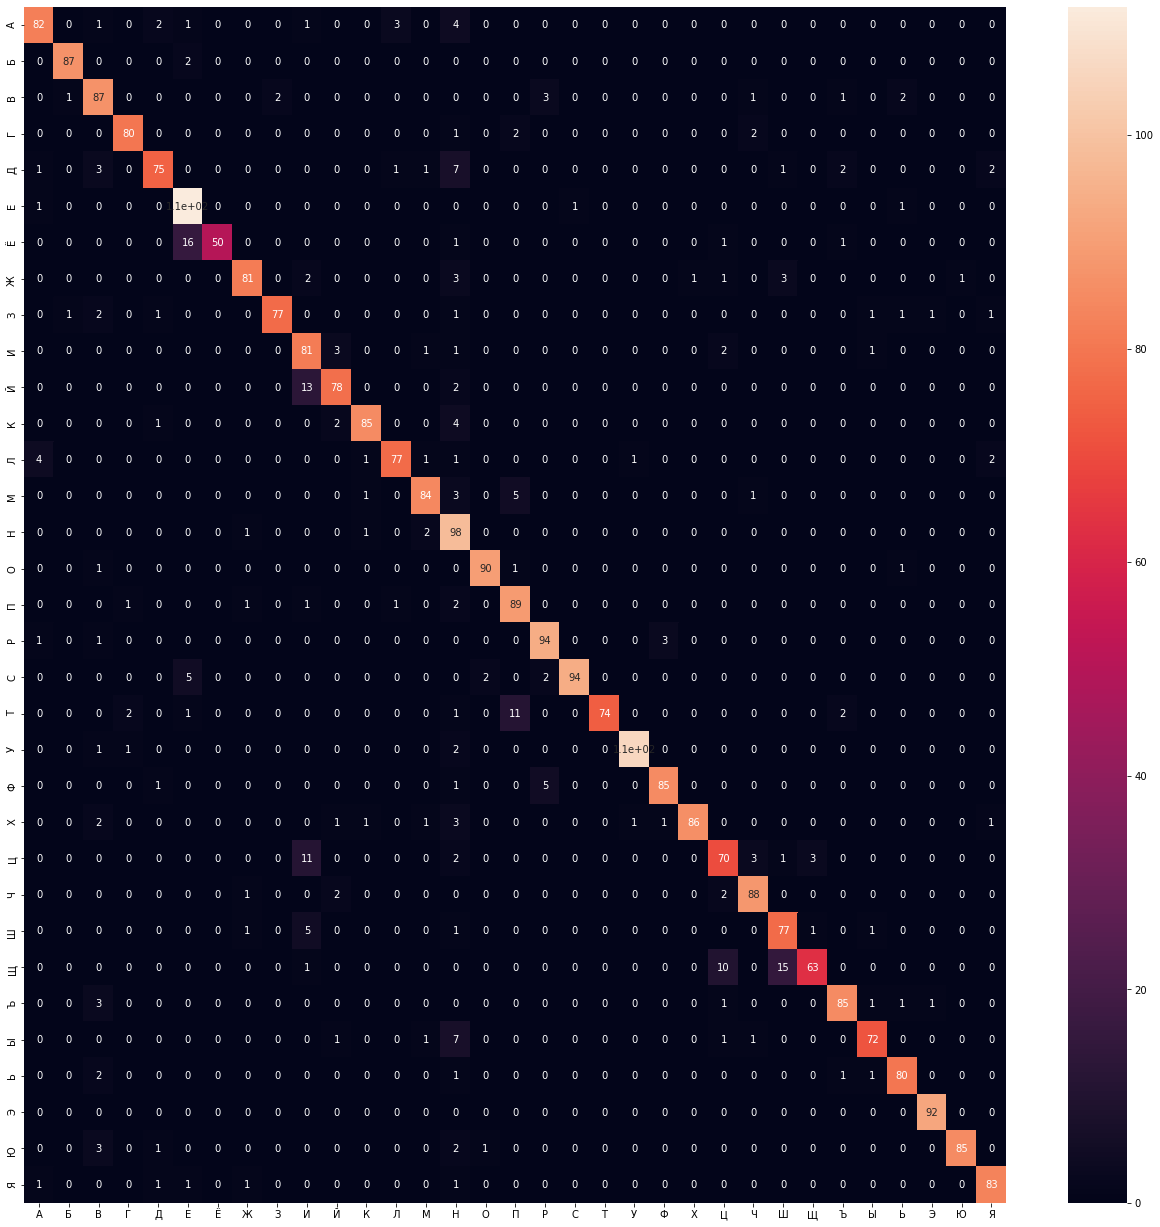

In [45]:
df_cm = pd.DataFrame(cm, index = [i for i in alfabeto],
                  columns = [i for i in alfabeto])
plt.figure(figsize = (22,22))
sn.heatmap(df_cm, annot=True)

Arriba podemos ver como se desempaña nuestro modelo, viendo que clase clasifica como tal y con cual se confunde.

### 16) Reporte y más métricas

El  <strong>true positive rate, sensitivity o recall </strong>, representa el porcentaje de positivos correctamente inferidos por cada positivo real"

La <strong>precisión</strong> será "cuántos se clasificaron correctamente entre esa clase"

La <strong>puntuación f1 /f1-score</strong> es la media armónica entre la precisión y el recall.

El <strong>soporte/support</strong> es el número de ocurrencias de la clase dada en su conjunto de datos

In [46]:
print(metrics.classification_report(y_test, y_pred, target_names=list("АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ")))

              precision    recall  f1-score   support

           А       0.91      0.87      0.89        94
           Б       0.98      0.98      0.98        89
           В       0.82      0.90      0.86        97
           Г       0.95      0.94      0.95        85
           Д       0.91      0.81      0.86        93
           Е       0.81      0.97      0.89       115
           Ё       1.00      0.72      0.84        69
           Ж       0.94      0.88      0.91        92
           З       0.97      0.90      0.93        86
           И       0.70      0.91      0.79        89
           Й       0.90      0.84      0.87        93
           К       0.96      0.92      0.94        92
           Л       0.94      0.89      0.91        87
           М       0.92      0.89      0.91        94
           Н       0.66      0.96      0.78       102
           О       0.97      0.97      0.97        93
           П       0.82      0.94      0.88        95
           Р       0.90    

### 17) Curva ROC y AUC
---
La curva ROC (Receiver Operator Characteristic) es una métrica de evaluación para problemas de clasificación. Es una curva de probabilidad que traza el TPR contra el FPR en varios valores de umbral. El área bajo la curva (AUC) es la medida de la capacidad de un clasificador para distinguir entre clases y se utiliza como resumen de la curva ROC.

#### *Cuanto mayor sea el AUC, mejor será el rendimiento del modelo a la hora de distinguir entre las clases positivas y negativas.*


Para generar la curva de ROC hacemos lo siguiente

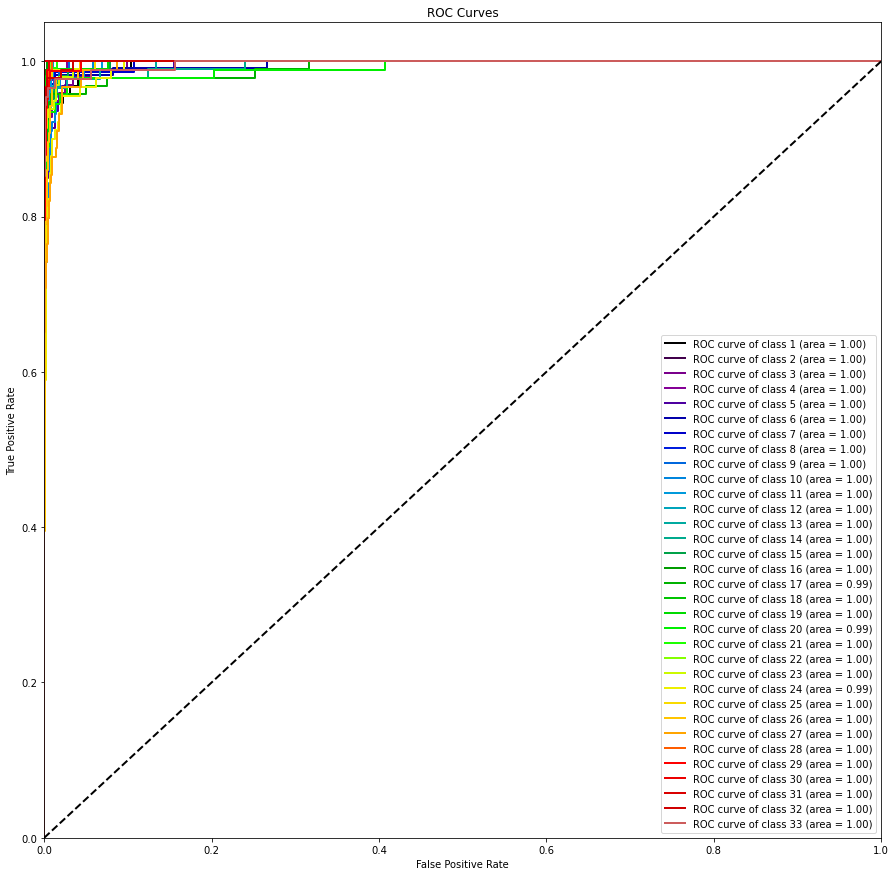

In [47]:
probabilities = svm.predict_proba(X_test_pca)

skplt.metrics.plot_roc(y_test, probabilities, plot_micro=False, plot_macro=False,figsize=(15,15))
plt.show()

In [48]:
y_score = svm.predict_proba(X_test_pca)

In [49]:
fpr1, tpr1, thresh1 = roc_curve(y_test, y_score[:,1], pos_label=1)
auc = roc_auc_score(y_test, y_score, multi_class = 'ovr', average = 'weighted')
print('Area bajo la curva:  %.6f' % auc)

Area bajo la curva:  0.997747


### 18) Generación de una letra para probar en el modelo
---
Para verificar si el modelo funciona correctamente, decidí crear una imagen en el paint para probar, y la guarde en la carpeta donde se encuentra el dataset y la nombré "prueba.png"

Acá simplement obtengo la imagen y le reduzco su tamaño

In [50]:
img_prueba = Image.open("dataset/prueba.png")
img_prueba_array = np.array(img_prueba)
img_prueba_recortada =cv.resize(img_prueba_array,(64,64))
img_prueba_recortada.shape

(64, 64, 4)

Hago a la imagen blanco y negro y la muestro

(64, 64)

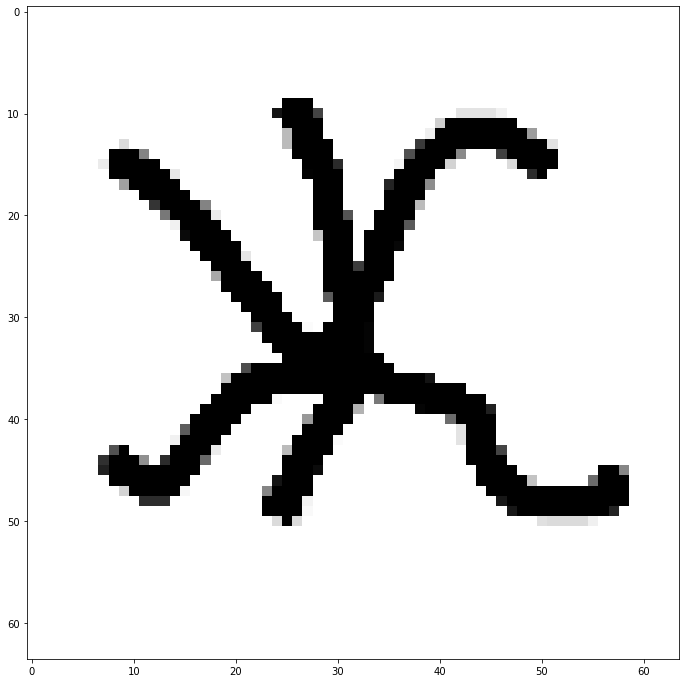

In [51]:
imagen_prueba_gris = cv.cvtColor(img_prueba_recortada, cv.COLOR_BGR2GRAY)
plt.imshow(imagen_prueba_gris, cmap=mpl.cm.gray)
imagen_prueba_gris.shape

Aplico el filtro gaussiano

(64, 64)

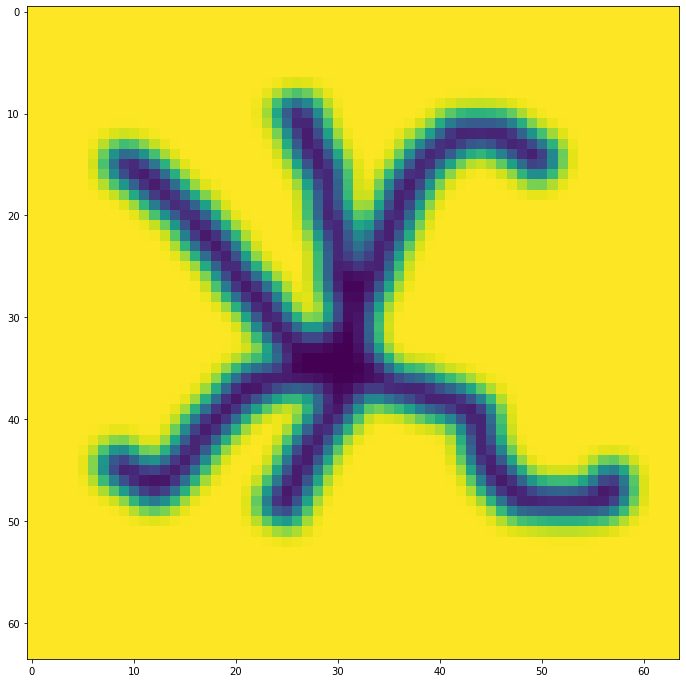

In [52]:
image_prueba_blur = cv.GaussianBlur(imagen_prueba_gris,(5,5),0)
plt.imshow(image_prueba_blur)
image_prueba_blur.shape


Obtengo la matriz HOG de la image

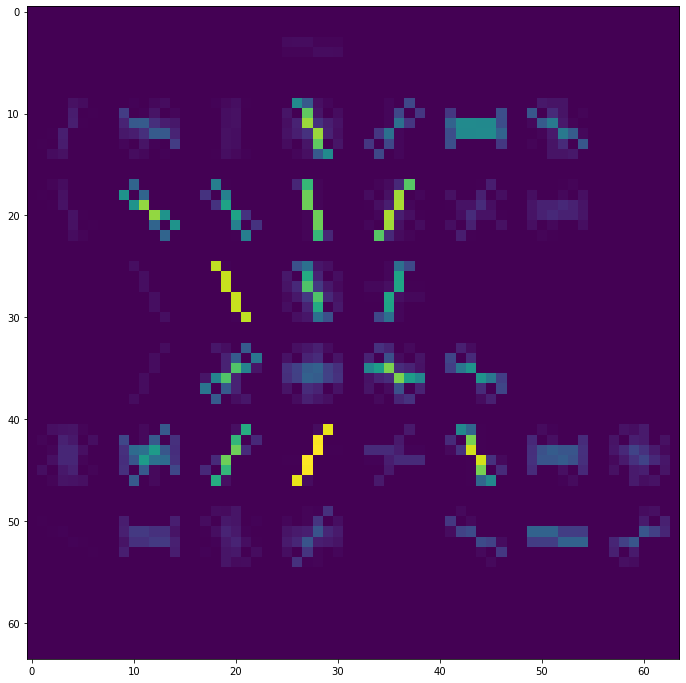

In [53]:
hog_prueba,hog_image = hog(image_prueba_blur,visualize=True,orientations=8, block_norm='L2-Hys', pixels_per_cell=(8, 8),cells_per_block=(2,2))
plt.imshow(hog_image)

Necesito que esto sea un array de dos dismensiones por eso hago un reshape

In [54]:
hog_prueba.shape

(1568,)

In [55]:
hog_prueba=hog_prueba.reshape(-1,1)
hog_prueba.shape

(1568, 1)

Normalizo los datos

In [56]:

hog_prueba_scaled=sc.transform(hog_prueba.transpose())
hog_prueba_scaled.shape

(1, 1568)

Le aplico PCA a la imagen para reducir sus dimensiones

In [57]:
letra_prueba=pca.transform(hog_prueba_scaled)
letra_prueba.shape

(1, 575)

Obtengo la predicción

In [58]:
y_pred = svm.predict(letra_prueba)
y_pred[0]

8

El resultado de la predicción es 8, que corresponde con la octava letre del alfabeto, para solucionar esto, de no andar acordandome las letras, cree un diccionario "key:value", de la forma   númbero_de_letra:Letra, para loopear, la misma y obtener la letra.

In [59]:
res = {np.linspace(1,33,33)[i]: list(alfabeto)[i] for i in range(len(np.linspace(1,33,33)))}
res

{1.0: 'А',
 2.0: 'Б',
 3.0: 'В',
 4.0: 'Г',
 5.0: 'Д',
 6.0: 'Е',
 7.0: 'Ё',
 8.0: 'Ж',
 9.0: 'З',
 10.0: 'И',
 11.0: 'Й',
 12.0: 'К',
 13.0: 'Л',
 14.0: 'М',
 15.0: 'Н',
 16.0: 'О',
 17.0: 'П',
 18.0: 'Р',
 19.0: 'С',
 20.0: 'Т',
 21.0: 'У',
 22.0: 'Ф',
 23.0: 'Х',
 24.0: 'Ц',
 25.0: 'Ч',
 26.0: 'Ш',
 27.0: 'Щ',
 28.0: 'Ъ',
 29.0: 'Ы',
 30.0: 'Ь',
 31.0: 'Э',
 32.0: 'Ю',
 33.0: 'Я'}

Buscamos la letra en el diccionario

In [60]:
if y_pred[0] in res:
    print(f"Letra predicha: {res[y_pred[0]]}")

Letra predicha: Ж


In [61]:
probabilidad_letra_elegida=svm.predict_proba(letra_prueba)
porcentaje=0
for item in probabilidad_letra_elegida[0]:
    porcentaje+=item
print(f"Porcentaje de probabilidad: {porcentaje}")

Porcentaje de probabilidad: 1.0000000000000004
